In [63]:
import pandas as pd
pd.options.display.max_colwidth = 4000
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pickle
import seaborn as sns
import random
import itertools
import re
from collections import Counter
from wordcloud import WordCloud
import scipy.stats as stats
from scipy.stats import norm

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import gensim.downloader

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Embedding, Reshape, GlobalMaxPooling1D, Bidirectional, Dropout, Lambda
from tensorflow.keras.layers import LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1002)>


In [64]:
# Preprocessing
def basic_processing(df):
    words_to_remove = ["e.g.", "code", "may", "attack", "system", "adversary", "Adversaries"]
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: x.replace(word, ''))
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: re.sub(r'\b' + re.escape(word) + r'\b', '', x))

    # df['NameDesc'] = df['NameDesc'].str.replace(r"\b(" + "|".join(words_to_remove) + r")\b", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("<br><br>", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("\(Citation:.*?\)", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("http\S+", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("  +", " ", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("[^A-Za-z]", " ", regex=True)
    return df

def rm_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['NameDesc'] = df['NameDesc'].apply(lambda x: [word for word in x if word not in stop_words])
    # print(f"Removed stopwords:\n {df.head(3).NameDesc}\n")
    return df

def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
        return lemmas
    df['NameDesc'] = df['NameDesc'].apply(lambda x: lemmatize_tokens(x))
    # print(f"Lemmatized words:\n {df.head(3).NameDesc}")
    return df

def text_preprocessing(df):
    basic_processing(df)
    df['NameDesc'] = df['NameDesc'].apply(lambda x: word_tokenize(x))
    rm_stopwords(df)
    lemmatize(df)

    k = random.randint(0, len(df)) # arbitary row to show that words have been removed
    print(f"Bef rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    df['NameDesc'] = df['NameDesc'].apply(lambda x: list(set([word.lower() for word in x]))) # to remove duplicates
    print(f"Aft rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    print(f"Removed duplicates:\n {df.head(3).NameDesc}")

    print("=========================================")
    return df

<h3>Fuzzy clustering<h3>

In [ ]:
df = pd.read_excel('data/raw_capec_data.xlsx', sheet_name="Threats")
df["NameDesc"] = df["Name"] + " " + df["Desc"]
df['NameDesc'] = df['NameDesc'].astype(str)

corpus = df['NameDesc']

with open('model/vectorizer.pickle', 'rb') as fin:
    tfidf = pickle.load(fin)

X = tfidf.transform(corpus).toarray()

n_clusters = 6

# Fuzzy C-Means algorithm
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X.T, n_clusters, m=2, error=0.005, maxiter=1000
)

cluster_membership = np.argmax(u, axis=0)

df['Cluster'] = cluster_membership
df['STRIDE'] = df[['S', 'T', 'R', 'I', 'D', 'E']].astype(str).agg(''.join, axis=1)

print(df[['STRIDE', 'Cluster']].head(3))

In [ ]:
stride_counts_per_cluster = df.groupby('Cluster')['STRIDE'].nunique()
    
for cluster, group in df.groupby('Cluster'):
    unique_values = group['STRIDE'].unique()
    print(f"Cluster {cluster} - Unique STRIDE Values: {unique_values}")

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.hist(u[i], bins=20, alpha=0.5, label=f'Cluster {i}')

plt.title('Fuzzy C-Means Membership Distribution')
plt.xlabel('Membership Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<h3>Extracting more keywords<h3>

In [65]:
df = pd.read_excel('data/mitre-classified.xlsx')

def change_label(df):
    stride_mapping = { # STRIDE
        1: 1, # E
        10: 2, # D
        100: 3, # I
        1000: 4, # R
        10000: 5, # T
        100000: 0, # S
        11000: 4,
        100100: 0
    }
    df['STRIDE'] = df['STRIDE'].map(stride_mapping)

while True:
    df_train, temp = train_test_split(df, test_size=0.3)
    df_test, df_dev = train_test_split(temp, test_size=1/3)

    change_label(df_train)
    change_label(df_test)
    change_label(df_dev)

    c = set([0, 1, 2, 3, 4, 5])
    if set(df_train['STRIDE'].unique()) != c or \
        set(df_test['STRIDE'].unique()) != c or \
        set(df_dev['STRIDE'].unique()) != c:
            continue
    else:
        break
    
col_toDrop = ['Ref', 'Name', 'Desc', 'Confidentiality', 'Integrity', 'Availability', 'Ease Of Exploitation', 'References', 'Unnamed: 0']
df_train = df_train.reset_index(drop=True).drop(columns=col_toDrop)
df_test = df_test.reset_index(drop=True).drop(columns=col_toDrop)
df_dev = df_dev.reset_index(drop=True).drop(columns=col_toDrop)

display(df_train.head(1))
print(f"df_train:\n{df_train['STRIDE'].value_counts()}\n")
print(f"df_dev:\n{df_dev['STRIDE'].value_counts()}\n")
print(f"df_test:\n{df_test['STRIDE'].value_counts()}")
# print((df_train.iloc[0]['NameDesc']))

,NameDesc,STRIDE
0,"Windows Service Adversaries may create or modify Windows services to repeatedly execute malicious payloads as part of persistence. When Windows boots up, it starts programs or applications called services that perform background system functions.(Citation: TechNet Services) Windows service configuration information, including the file path to the service's executable or recovery programs/commands, is stored in the Windows Registry.<br><br>Adversaries may install a new service or modify an existing service to execute at startup in order to persist on a system. Service configurations can be set or modified using system utilities (such as sc.exe), by directly modifying the Registry, or by interacting directly with the Windows API. <br><br>Adversaries may also use services to install and execute malicious drivers. For example, after dropping a driver file (ex: `.sys`) to disk, the payload can be loaded and registered via [Native API](https://attack.mitre.org/techniques/T1106) functions such as `CreateServiceW()` (or manually via functions such as `ZwLoadDriver()` and `ZwSetValueKey()`), by creating the required service Registry values (i.e. [Modify Registry](https://attack.mitre.org/techniques/T1112)), or by using command-line utilities such as `PnPUtil.exe`.(Citation: Symantec W.32 Stuxnet Dossier)(Citation: Crowdstrike DriveSlayer February 2022)(Citation: Unit42 AcidBox June 2020) Adversaries may leverage these drivers as [Rootkit](https://attack.mitre.org/techniques/T1014)s to hide the presence of malicious activity on a system. Adversaries may also load a signed yet vulnerable driver onto a compromised machine (known as ""Bring Your Own Vulnerable Driver"" (BYOVD)) as part of [Exploitation for Privilege Escalation](https://attack.mitre.org/techniques/T1068).(Citation: ESET InvisiMole June 2020)(Citation: Unit42 AcidBox June 2020)<br><br>Services may be created with administrator privileges but are executed under SYSTEM privileges, so an adversary may also use a service to escalate privileges. Adversaries may also directly start services through [Service Execution](https://attack.mitre.org/techniques/T1569/002). To make detection analysis more challenging, malicious services may also incorporate [Masquerade Task or Service](https://attack.mitre.org/techniques/T1036/004) (ex: using a service and/or payload name related to a legitimate OS or benign software component).<br><br>Monitor processes and command-line arguments for actions that could create or modify services. Command-line invocation of tools capable of adding or modifying services may be unusual, depending on how systems are typically used in a particular environment. Services may also be modified through Windows system management tools such as [Windows Management Instrumentation](https://attack.mitre.org/techniques/T1047) and [PowerShell](https://attack.mitre.org/techniques/T1059/001), so additional logging may need to be configured to gather the appropriate data. Remote access tools with built-in features may also interact directly with the Windows API to perform these functions outside of typical system utilities. Collect service utility execution and service binary path arguments used for analysis. Service binary paths may even be changed to execute commands or scripts. <br><br>Look for changes to service Registry entries that do not correlate with known software, patch cycles, etc. Service information is stored in the Registry at <code>HKLM\SYSTEM\CurrentControlSet\Services</code>. Changes to the binary path and the service startup type changed from manual or disabled to automatic, if it does not typically do so, may be suspicious. Tools such as Sysinternals Autoruns may also be used to detect system service changes that could be attempts at persistence.(Citation: TechNet Autoruns) <br><br>Creation of new services may generate an alterable event (ex: Event ID 4697 and/or 7045 (Citation: Microsoft 4697 APR 2017)(Citation: Microsoft Windows Event 

df_train:
STRIDE
1    147
3    114
5     51
0     20
2      5
4      2
Name: count, dtype: int64

df_dev:
STRIDE
1    20
3    17
5     5
0     4
2     2
4     1
Name: count, dtype: int64

df_test:
STRIDE
1    49
3    22
0    10
5    10
2     4
4     2
Name: count, dtype: int64


In [66]:
text_preprocessing(df_train)
text_preprocessing(df_test)
text_preprocessing(df_dev)

Bef rm duplicates: 81
Aft rm duplicates: 54
Removed duplicates:
 0    [function, startup, activity, onto, tools, connection, system, tool, exist, include, utility, windows, part, could, path, network, monitor, alterable, gather, your, relate, privilege, administrator, change, services, configure, management, software, hide, make, disk, component, show, leverage, modify, repeatedly, add, own, executable, configuration, masquerade, access, patch, via, challenge, process, currentcontrolset, attempt, tree, compromise, invocation, sysinternals, technique, information, sys, argument, value, to, boot, file, malicious, zwloaddriver, compare, even, api, drop, line, load, particular, create, install, example, set, registry, instrumentation, powershell, command, outside, detect, behavior, manual, control, driver, pnputil, manually, program, for, legitimate, name, event, changes, os, execution, presence, chain, service, sign, perform, suspicious, vulnerable, ...]
1                                 

,NameDesc,STRIDE
0,"[source, activity, high, network, seek, gather, content, databases, visibility, potentially, difficult, make, engine, keywords, spillage, credential, access, form, compromise, site, actor, place, provide, query, accounts, context, information, focus, harvest, index, lifecycle, defender, effort, syntax, threat, take, victim, outside, phishing, operational, craft, leak, user, reconnaissance, positive, engines, stage, associate, false, well, service, opportunity, various, online, organization, detection, search, specific, filetypes, depend, look, crawl, target, type, use, detail, initial, related, reveal, occurrence, general, establish, e, sensitive, technical, resource, ex, collect, open, specialized, valid, rate, typical]",3
1,"[useful, activity, specifically, setthreadtoken, audit, exist, false, windows, detailed, network, manipulation, shell, monitor, impersonate, suspicious, duplicatetoken, impersonation, privilege, session, line, logon, administrator, benign, default, create, an, reduce, escalate, thread, assign, impersonateloggedonuser, example, enable, runas, due, positive, bypass, command, security, if, behavior, detect, control, the, log, want, apis, target, correlate, normal, access, ex, specific, look, process, standard, for, theft, call, user, allow, non, another, token, new, also, duplicate, analyst, analysts, use, context]",1
2,"[cause, attribute, startup, activity, system, x, possible, windows, spoof, part, utility, could, relationship, indicate, monitor, privilege, administrator, ppid, field, potentially, identifies, access, actual, process, via, provide, identifier, context, information, createprocess, correctly, inherit, malicious, unless, consent, compare, inconsistency, api, createprocessa, account, produce, ppids, basic, creator, create, necessary, explorer, example, set, enable, powershell, behavior, control, processid, normal, spoofing, one, for, run, office, manager, name, event, user, evade, mechanism, proceed, functionality, parameter, positive, privileged, xxx, support, way, false, within, perform, pid, various, document, block, parent, generate, directly, task, specify, spearphishing, attachment, assign, update, feature, analyze, execute, child, exe, spawn, unusual, the, log, tracing, ...]",1
3,"[activity, high, direct, include, market, gather, content, services, visibility, potentially, difficult, make, purchase, gathering, black, credential, access, form, via, password, attempt, compromise, site, place, accounts, business, dump, information, focus, elicitation, lifecycle, malicious, defender, effort, account, set, take, victim, outside, phishing, operational, leak, user, cooky, repository, reconnaissance, positive, engines, stage, domains, associate, way, false, well, opportunity, various, online, organization, external, detection, credentials, directly, search, web, website, tendency, accessible, breach, authentication, target, use, initial, data, adversary, related, advantage, reveal, potential, occurrence, establish, across, personal, etc, expose, resource, remote, design, ex, collect, open, rate, valid, websites, visitor, also, dark]",3
4,"[source, function, activity, developer, system, base, include, windows, part, could, network, monitor, follow, gather, malware, hkey, interaction, infer, geographical, on, configuration, process, attempt, currentcontrolset, locale, query, technique, information, argument, enforcement, value, operator, infects, local, api, shape, line, example, vary, registry, agency, lang, command, take, victim, there, behavior, control, attention, getuserdefaultlangid, parse, for, variable, operation, event, decision, normally, risk, occur, chain, various, learns, nls, obtain, getsystemdefaultuilanguage, action, check, macos, location, whether, linux, entity, lead, machine, involve, getkeyboardlayoutlist, specific, employ, scrutiny, this, key, getuserdefaultuilanguage, target, use, output, isolation, view, native, data, adversary, host, default, reduce, di

#### STRIDE MAPPING:
S  T  R  I  D  E \
0  5  4  3  2  1

<h3>Manually filter out words<h3>

In [67]:
df_train.loc[df_train['STRIDE']==0]['NameDesc']

18                                                                                                                                    [domain, activity, high, direct, include, path, relationship, network, gather, visibility, software, potentially, difficult, make, trusted, supply, gathering, manage, access, form, via, compromise, place, accounts, business, information, focus, elicitation, lifecycle, drive, defender, second, effort, set, provider, take, victim, social, owned, outside, phishing, operational, positive, reconnaissance, stage, domains, party, associate, way, false, variety, chain, well, connect, service, hardware, opportunity, various, online, organization, detection, search, accessible, this, media, target, use, elevate, detail, initial, data, adversary, related, reveal, occurrence, establish, third, etc, expose, relationships, resource, shipment, contractor, ex, open, rate, websites, also]
23                                                                                 

In [68]:
# predefined keywords for each STRIDE category

S = ['authenticate', 'username', 'password', 'access'] #add more words
T = ['modify', 'persistent', 'database', 'alter', 'open', 'network', 'internet'] #add more words
R = ['deny', 'action', 'prove', 'non-repudiation', 'item', 'sign', 'receipt', 'receive', 'evidence', 'package', 'untrace',]
I = ['exposure', 'individual', 'access', 'file', 'granted', 'intruder', 'transit']
D = ['denial', 'service', 'dos', 'web', 'server', 'unavailable', 'unusable', 'system', 'available', 'reliable']
E = ['unprivileged', 'privileged', 'access', 'compromise', 'entire', 'system', 'elevation', 'penetrate', 'defenses', 'untrusted', 'trusted']

In [51]:
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
keyw = {}
for s, tkcounts in token_counts_by_group.items():
    for key, num in tkcounts.items():
        keyw.setdefault(s, []).append(key)
keyw

{0: ['require',
  'observe',
  'execution',
  'client',
  'indication',
  'engineering',
  'direct',
  'include',
  'file',
  'malicious',
  'exploitation',
  'network',
  'document',
  'follow',
  'gain',
  'organization',
  'visit',
  'typically',
  'links',
  'an',
  'action',
  'subject',
  'get',
  'spearphishing',
  'technique',
  'potentially',
  'execute',
  'order',
  'application',
  'download',
  'lead',
  'virus',
  'social',
  'link',
  'behavior',
  'detect',
  'computer',
  'click',
  'rely',
  'browser',
  'phishing',
  'vulnerability',
  'via',
  'this',
  'traffic',
  'campaign',
  'users',
  'user',
  'site',
  'anti',
  'clicking',
  'also',
  'upon',
  'route',
  'base',
  'windows',
  'spoof',
  'transmitted',
  'indicate',
  'monitor',
  'low',
  'malware',
  'change',
  'ack',
  'communication',
  'interaction',
  'sent',
  'ip',
  'many',
  'middle',
  'especially',
  'own',
  'credential',
  'configuration',
  'provide',
  'through',
  'insecure',
  'informati

/Users/chufeng/Documents/IARCS internship/code/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1986: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


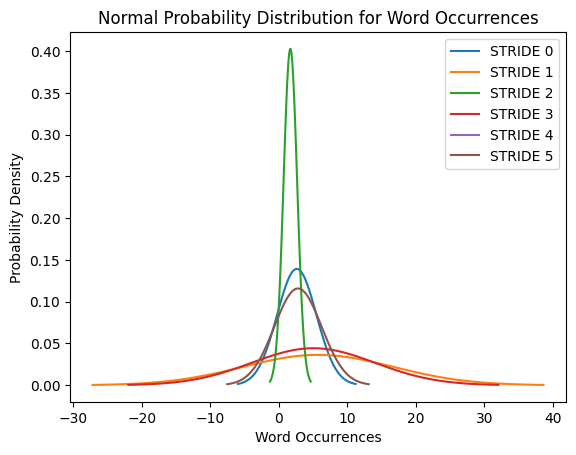

In [52]:
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

# prob distribution for word occurrence of entire corpus
def plot_normal_dist(token_counts_by_group):
    for stride_value, token_count in token_counts_by_group.items():
        mu = np.mean(list(token_count.values()))
        sigma = np.std(list(token_count.values()))
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=f'STRIDE {stride_value}')

    plt.title('Normal Probability Distribution for Word Occurrences')
    plt.xlabel('Word Occurrences')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

# Assuming df_train is your DataFrame
token_counts_by_group = word_occurrence_by_group(df_train)
plot_normal_dist(token_counts_by_group)

In [69]:
# words to keep (manual)
S_keep = ['information', 'detection', 'take',  'include', 'malicious', 'control', 'network', 'search', 'name', 'access', 'infrastructure', 'traffic', 'data', 'suspicious', 'trust', 'reconnaissance', 'email', 'phishing', 'resource', 'initial', 'visibility', 'monitor', 'server', 'form', 'open', 'potentially', 'websites', 'address', 'process', 'detect', 'credential', 'file', 'certificate', 'internet', 'install', 'key', 'online', 'link', 'source']
E_keep = ['process', 'access', 'file', 'execute', 'activity', 'execution', 'network', 'behavior', 'create', 'control', 'log', 'privilege', 'application', 'service', 'within', 'event', 'account', 'modify', 'run', 'abuse', 'monitoring', 'environment', 'binary', 'credential', 'enable', 'api', 'exe', 'function', 'payload', 'target', 'method', 'services', 'launch', 'root', 'os', 'many''accounts']
D_keep = ['service', 'target', 'tool', 'command', 'cause', 'server', 'network', 'outside', 'denial', 'dos', 'availability', 'high', 'destruction', 'infrastructure']
I_keep = ['data', 'network', 'activity', 'access', 'behavior', 'environment', 'process', 'detection', 'remote', 'base', 'target', 'tool', 'file', 'api', 'traffic', 'acquire', 'application', 'host', 'infrastructure', 'device']
R_keep = ['user', 'application', 'api', 'activity', 'audit', 'source', 'system', 'native', 'hide', 'error', 'intrusion', 'function', 'record', 'clear', 'gcp', 'permission', 'analysis', 'collection', 'updatesink', 'indicate', 'detection', 'data', 'collect', 'environment', 'call', 'limit', 'cloudtrail', 'loss', 'conduct', 'prior', 'delete', 'cloud', 'configservicev', 'cloudwatch', 'diagnostic', 'capability', 'sufficient', 'insight', 'avoid']
T_keep = ['malicious', 'file', 'activity', 'process', 'execute', 'access', 'information', 'control', 'software', 'modify', 'network', 'data', 'abuse', 'exe', 'manipulate', 'bypass', 'malware', 'functionality', 'integrity', 'dll', 'anomaly', 'install']

In [70]:
# combine both lists together by group
S_final = S + S_keep
T_final = T + T_keep
R_final = R + R_keep
I_final = I + I_keep
D_final = D + D_keep
E_final = E + E_keep

In [71]:
df_train.head(20)

,NameDesc,STRIDE
0,"[function, startup, activity, onto, tools, connection, system, tool, exist, include, utility, windows, part, could, path, network, monitor, alterable, gather, your, relate, privilege, administrator, change, services, configure, management, software, hide, make, disk, component, show, leverage, modify, repeatedly, add, own, executable, configuration, masquerade, access, patch, via, challenge, process, currentcontrolset, attempt, tree, compromise, invocation, sysinternals, technique, information, sys, argument, value, to, boot, file, malicious, zwloaddriver, compare, even, api, drop, line, load, particular, create, install, example, set, registry, instrumentation, powershell, command, outside, detect, behavior, manual, control, driver, pnputil, manually, program, for, legitimate, name, event, changes, os, execution, presence, chain, service, sign, perform, suspicious, vulnerable, ...]",1
1,"[structure, domain, http, associate, client, embed, carry, packet, header, exist, within, never, avoid, could, common, network, monitor, data, follow, suspicious, adversary, receives, bad, content, detection, communicate, send, significantly, protocol, field, conceal, syntax, an, know, communication, https, regard, abuse, s, blending, filter, analyze, flow, server, application, often, web, command, many, victim, leverage, protocols, remote, processes, detect, control, result, uncommon, normally, see, normal, utilize, environment, traffic, commands, standard, variable, layer, mimic, also, expect, use]",3
2,"[stage, back, activity, associate, popular, base, exist, focus, possible, variety, register, lifecycle, service, later, common, a, using, offer, effort, adversary, related, organization, detection, services, know, visibility, software, abuse, once, difficult, physically, hide, make, web, command, leverage, take, much, outside, tie, behavior, expect, infrastructure, control, over, noise, website, google, utilize, ex, look, easy, characteristic, twitter, operation, place, by, target, use, unique, exfiltration]",2
3,"[function, opening, anonymous, connection, trace, base, windows, avoid, could, path, similarly, network, monitor, malware, relate, runtime, except, potentially, disk, otherwise, instead, executable, process, separate, compromise, memory, back, present, vice, file, malicious, common, masked, api, notepad, load, create, since, example, enable, ram, behavior, allocate, clr, arbitrary, involves, for, legitimate, signature, evade, mechanism, code, mscor, memfd, execution, associate, reflectively, within, injection, sign, usually, perform, suspicious, detection, obfuscate, directly, encrypt, action, analyze, execute, exe, independent, reading, similar, use, assembly, reflective, compile, createthread, shell, native, abnormal, related, payload, benign, etw, conceal, fileless, abuse, thread, execve, artifact, order, language, net, amsi, identify, ex, position, dll, ...]",1
4,"[connection, client, tool, direct, exist, include, inside, ride, avoid, never, path, port, network, c, follow, true, content, communicate, communication, zxportmap, many, manage, redirection, compromise, provide, expect, zxproxy, common, smb, enable, flow, command, destination, behavior, detect, control, one, resiliency, traffic, another, by, normally, two, well, blend, suspicious, external, protocol, proxy, htran, analyze, peer, outbound, internal, need, trust, see, simultaneous, infect, use, packet, data, adversary, conceal, networking, p, loss, reduce, often, processes, uncommon, numerous, utilize, environment, number, suspicion, face]",3
5,"[script, group, sysmon, execution, specifically, associate, connection, policy, base, evasion, include, utility, windows, well, scripting, file, malicious, usage, network, without, various, perform, monitor, extension, prevent, line, detection, payload, indirect, possibly, invoke, window, subvert, host, abuse, wsl, forfiles, example, linux, feature, execute, analyze, child, component, interpreter, bypass, e

In [72]:
w2v = gensim.downloader.load('word2vec-google-news-300')

In [13]:
stride_sets = {0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set()}

for index, row in df_train.iterrows():
    stride_value = row['STRIDE']
    if stride_value in stride_sets:
        name_desc_list = row['NameDesc']
        stride_sets[stride_value].update(name_desc_list)

stride_lists = {stride_value: list(words) for stride_value, words in stride_sets.items()}

def average_cosine_similarity(list1, list2, model):
    list1_vectors = [model.get_vector(word) for word in list1 if word in model.key_to_index]
    list2_vectors = [model.get_vector(word) for word in list2 if word in model.key_to_index]
    
    if not list1_vectors or not list2_vectors:
        return None
    
    cosine_sim_matrix = np.dot(list1_vectors, np.transpose(list2_vectors))
    average_cosine_sim = np.mean(cosine_sim_matrix)
    return average_cosine_sim

avg_cosine_sim = average_cosine_similarity(df_train.loc[0, 'NameDesc'], S_final, w2v)
print("Average Cosine Similarity:", avg_cosine_sim)

Average Cosine Similarity: 0.8889633


In [73]:
def merge_lists(l1, min_cosine_value, w2v, ref_list):
    final_list = []
    
    for word in l1:
        if word in w2v:
            similarities = []
            for ref_word in ref_list:
                if ref_word in w2v:
                    sim = w2v.similarity(word, ref_word)
                    similarities.append(sim)
            if any(sim >= min_cosine_value for sim in similarities):
                final_list.append(word)
    return final_list

list1 = ["domain", "activity", "high", "direct", "include", "path", "relationship", "network", "gather", "visibility", "software", "potentially", "difficult", "make", "trusted", "supply", "gathering", "manage", "access", "form", "via", "compromise", "place", "accounts", "business", "information", "focus", "elicitation", "lifecycle", "drive", "defender", "second", "effort", "set", "provider", "take", "victim", "social", "owned", "outside", "phishing", "operational", "positive", "reconnaissance", "stage", "domains", "party", "associate", "way", "false", "variety", "chain", "well", "connect", "service", "hardware", "opportunity", "various", "online", "organization", "detection", "search", "accessible", "this", "media", "target", "use", "elevate", "detail", "initial", "data", "adversary", "related", "reveal", "occurrence", "establish", "third", "etc", "expose", "relationships", "resource", "shipment", "contractor", "ex", "open", "rate", "websites", "also"]

min_cosine_value = 0.33
reference_words = S_final

merged_list = merge_lists(list1, min_cosine_value, w2v, reference_words)
print(f"Resultant merged list: {merged_list}")
print(f"Words removed: {set(S_final) - set(merged_list)}")

Resultant merged list: ['domain', 'include', 'relationship', 'network', 'gather', 'visibility', 'software', 'potentially', 'make', 'trusted', 'manage', 'access', 'form', 'via', 'information', 'lifecycle', 'provider', 'take', 'phishing', 'operational', 'reconnaissance', 'domains', 'connect', 'service', 'hardware', 'online', 'organization', 'detection', 'search', 'accessible', 'media', 'use', 'initial', 'data', 'reveal', 'establish', 'expose', 'relationships', 'resource', 'open', 'websites']
Words removed: {'source', 'file', 'malicious', 'certificate', 'monitor', 'authenticate', 'suspicious', 'email', 'install', 'server', 'link', 'detect', 'control', 'trust', 'address', 'credential', 'internet', 'process', 'password', 'traffic', 'key', 'username', 'name', 'infrastructure'}


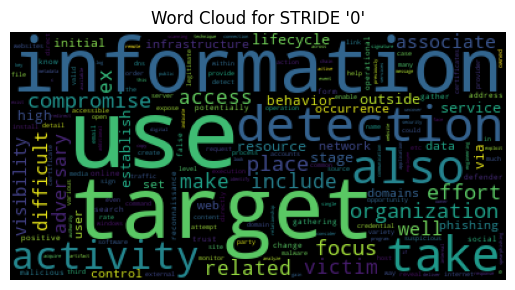

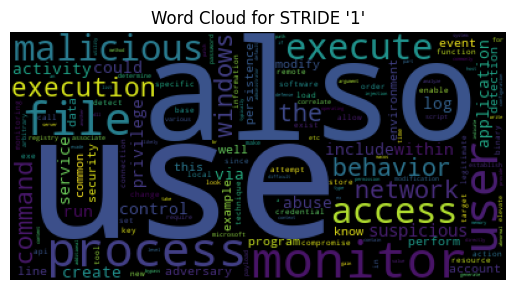

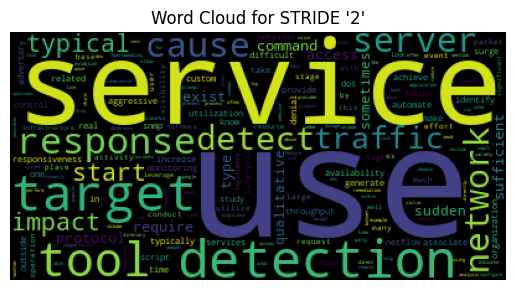

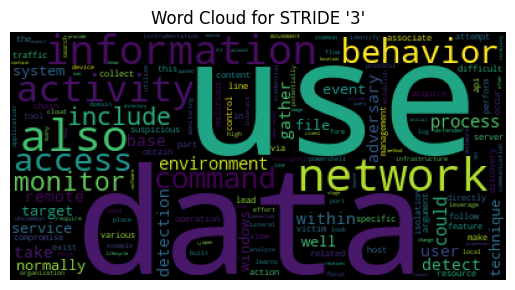

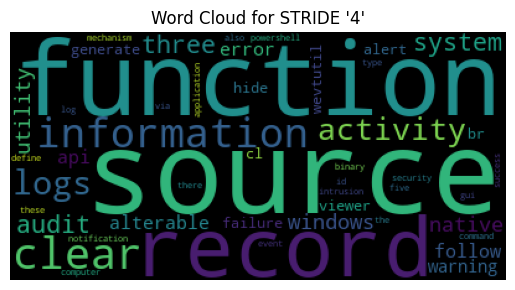

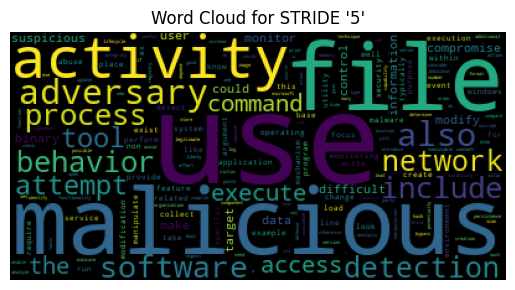

In [36]:
# Visualise word frequencies using word cloud
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
for stride_value, token_count in token_counts_by_group.items():
    wordcloud = WordCloud(background_color="black").generate_from_frequencies(token_count)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for STRIDE '{stride_value}'")
    plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

df_train['NameDesc'] = df_train['NameDesc'].apply(lambda x: ' '.join(x))
df_test['NameDesc'] = df_test['NameDesc'].apply(lambda x: ' '.join(x))
df_dev['NameDesc'] = df_dev['NameDesc'].apply(lambda x: ' '.join(x))

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['NameDesc']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(df_test['NameDesc']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(df_dev['NameDesc']).toarray()

y_train = df_train['STRIDE'].values
y_test = df_test['STRIDE'].values
y_val = df_dev['STRIDE'].values

In [ ]:
# hyperparameter tuning
# num_epochs = 50
# num_classes = 6
# vocab_size = X_train_tfidf.shape[1]
# dropout_rates = [0.2, 0.3, 0.4, 0.5]
# activations_list = ['relu', 'leaky_relu', 'elu', 'tanh']
# num_neurons = [32, 64, 128, 256]
# opt_lr = [1e-2, 1e-3, 1e-4]
# L2_lr = [1e-2, 1e-3, 1e-4]
# best_params = None
# best_val_acc = 0

# hyperparam_combi = itertools.product(dropout_rates, num_neurons, activations_list, opt_lr, L2_lr)

# for dr, nn, al, olr, l2lr in hyperparam_combi:
#     modelTest = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(vocab_size,)),
#     tf.keras.layers.Dense(nn*2, activation=al),
#     tf.keras.layers.Dropout(dr),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(nn, activation=al),
#     tf.keras.layers.Dropout(dr),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(nn//2, activation=al),
#     tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
#     ])

#     optimizer = tf.keras.optimizers.legacy.Adam(olr)
#     modelTest.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
#     early_stop = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         verbose=0,
#         restore_best_weights=True
#     )
#     histTest = modelTest.fit(
#         X_train_tfidf, y_train,
#         batch_size=16,
#         epochs=num_epochs,
#         validation_data=(X_val_tfidf, y_val),
#         verbose=0,
#         callbacks=[early_stop,]
#     )

#     val_acc = max(histTest.history['val_accuracy'])
#     # print(f"Dropout: {dr}, Activation: {al}, Hidden Units: {nn}, L2 Reg: {l2lr}, LR: {olr}, Best Val Acc: {val_acc}\n===========================")
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_params = (dr, nn, al, olr, l2lr)
# print(f"Final Best Hyperparameters: Dropout: {best_params[0]},\nActivation: {best_params[2]},\nHidden Units: {best_params[1]},\nL2 Reg: {best_params[4]},\nLR: {best_params[3]},\nBest Val Acc: {best_val_acc}")

In [ ]:
# model
hidden_units = 32
batch_size = 16
num_epochs = 50
num_classes = 6
classes = [0,1,2,3,4,5]
vocab_size = X_train_tfidf.shape[1]
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    tf.keras.layers.Dense(hidden_units*2, activation='elu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units, activation='elu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units//2, activation='elu'),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
])

model4.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model4.summary()
# plot_model(model4, show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def plot_graph(hist, model, X_val_padded, y_val, classes):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')


    y_pred = np.argmax(model.predict(X_val_padded), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [ ]:
hist4 = model4.fit(
    X_train_tfidf, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_tfidf, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

In [ ]:
plot_graph(
    hist=hist4,
    model=model4,
    X_val_padded=X_test_tfidf,
    y_val=y_test,
    classes=classes
)